In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re

## READ DATA

In [2]:
sheets = ["Station List Data", "Trip Data", "Weather Data"]
excel_file_path = 'Cartesian Bike Share Case Study - Data.xlsx'

sheets_dict = pd.read_excel(excel_file_path, sheet_name=None)

In [3]:
datasets = {}
for sheet_name, df in sheets_dict.items():
    if sheet_name in sheets:
        datasets[sheet_name] = df

In [4]:
station_data = datasets["Station List Data"]
trip_data = datasets["Trip Data"]
weather_data = datasets["Weather Data"]

## STATION DATA

In [5]:
station_data.head(5)

,id,terminal,station,municipal,lat,lng,status
0,3,B32006,Colleges of the Fenway,Boston,42.340021,-71.100812,Existing
1,4,C32000,Tremont St. at Berkeley St.,Boston,42.345392,-71.069616,Existing
2,5,B32012,Northeastern U / North Parking Lot,Boston,42.341814,-71.090179,Existing
3,6,D32000,Cambridge St. at Joy St.,Boston,42.361285,-71.06514,Existing
4,7,A32000,Fan Pier,Boston,42.353412,-71.044624,Existing


#### To check if there are any duplicate id's 

In [6]:
station_data[station_data.duplicated('id')]

,id,terminal,station,municipal,lat,lng,status
18,20,B32004,Aquarium Station - 200 Atlantic Ave.,Boston,42.35977,-71.051601,Existing
126,128,M32004,Kendall T at Main St,Cambridge,42.362457,-71.08497,Existing


#### We found duplicate values (id - 20, 128) we go ahead and investigate it further

In [7]:
station_data[station_data["id"] == 20]

,id,terminal,station,municipal,lat,lng,status
17,20,B32004,Aquarium Station - 200 Atlantic Ave.,Boston,42.35977,-71.051601,Existing
18,20,B32004,Aquarium Station - 200 Atlantic Ave.,Boston,42.35977,-71.051601,Existing


In [8]:
station_data[station_data["id"] == 128]

,id,terminal,station,municipal,lat,lng,status
125,128,M32004,Kendall T at Main St,Cambridge,42.362457,-71.08497,Existing
126,128,M32004,Kendall T at Main St,Cambridge,42.362457,-71.08497,Existing


#### As we can see both the duplicate id's have exactly same rows that means redundant data hence we can drop these duplicate rows and get the id to act as a unique identifier

In [9]:
station_data = station_data.drop_duplicates()

In [10]:
# Checking again if any more duplicates in id, hence we can go ahead and use id as the unique identifier
station_data[station_data.duplicated('id')]

,id,terminal,station,municipal,lat,lng,status


In [11]:
station_data.head(3)

,id,terminal,station,municipal,lat,lng,status
0,3,B32006,Colleges of the Fenway,Boston,42.340021,-71.100812,Existing
1,4,C32000,Tremont St. at Berkeley St.,Boston,42.345392,-71.069616,Existing
2,5,B32012,Northeastern U / North Parking Lot,Boston,42.341814,-71.090179,Existing


#### Checking for missing Values and found 3 missing values in status column

In [12]:
station_data.isna().sum()

id           0
terminal     0
station      0
municipal    0
lat          0
lng          0
status       3
dtype: int64

In [13]:
status_counts = station_data["status"].value_counts()
status_counts

status
Existing    127
Removed      12
Name: count, dtype: int64

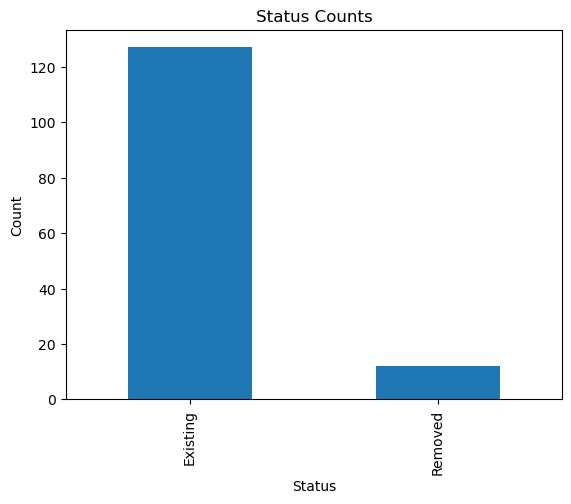

In [14]:
status_counts.plot(kind='bar')
plt.title("Status Counts")
plt.xlabel("Status")
plt.ylabel("Count")
plt.show()

#### for pre-processing or model training we can replace the missing values with "Existing" as status is a categorical variable with 2 categories and frequency of "Existing" is much more than other value

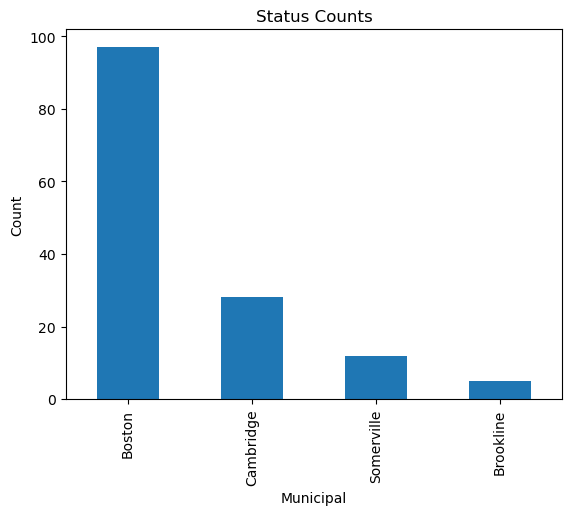

In [15]:
municipal_counts = station_data["municipal"].value_counts()
municipal_counts.plot(kind='bar')
plt.title("Status Counts")
plt.xlabel("Municipal")
plt.ylabel("Count")
plt.show()

In [16]:
# same for Municipal nothing much to talk about except the frequencies - Boston has the highest stations, followed by Cambridge and the rest of them

#### While trying to visualize the scatterplot between latitute and longitude, I found an error and on further investigation, I found out some values to be of a different type i.e. strings and not floats that have nothing to do with the latitudes / longitudes

In [17]:
converted_column = pd.to_numeric(station_data['lng'], errors='coerce')
station_data['lng'][converted_column.isna()]

135         Porter
138    Ball Square
Name: lng, dtype: object

In [18]:
converted_column = pd.to_numeric(station_data['lat'], errors='coerce')
station_data['lat'][converted_column.isna()]

135         Porter
138    Ball Square
Name: lat, dtype: object

#### As it turns out in both lat and lng columns at index 135 we have "Porter" and at index 138 we have "Ball Square" which I believe are the names of the locations in their respective Municipalities, we can get the correct latitude/ longitudes and replace them or we can just drop them for simplicity of this analysis

In [19]:
station_data = station_data[(station_data["lat"] != "Porter") & (station_data["lng"] != "Ball Square")]

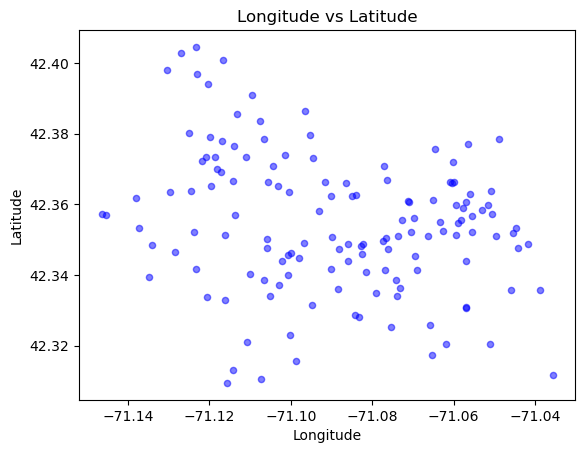

In [20]:
# Plot scatter plot for "lat" column
station_data.plot(kind='scatter', x='lng', y='lat', color='blue', alpha=0.5)

# Add labels and title
plt.title("Longitude vs Latitude")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

In [21]:
import folium
from folium.plugins import MarkerCluster


# Create a map centered around the mean of latitudes and longitudes
map = folium.Map(location=[station_data['lat'].mean(), station_data['lng'].mean()], zoom_start=13)

unique_muni = list(set(list(station_data["municipal"])))
color = ['red', 'blue', 'green', 'orange']

color_mapper = {v1 : v2 for v1, v2 in zip(unique_muni, color)}
print(color_mapper)

# Add markers to the map
marker_cluster = MarkerCluster().add_to(map)
for index, row in station_data.iterrows():

    folium.Marker([row['lat'], row['lng']], popup=row["municipal"], color = color_mapper[row["municipal"]]).add_to(marker_cluster)

# Display the map
map

{'Boston': 'red', 'Cambridge': 'blue', 'Somerville': 'green', 'Brookline': 'orange'}


In [22]:
station_data["status"].value_counts()

status
Existing    125
Removed      12
Name: count, dtype: int64

In [23]:
value_counts = station_data['terminal'].value_counts()

station_data['terminal_value_counts'] = station_data['terminal'].map(value_counts)

station_data.head(5)

,id,terminal,station,municipal,lat,lng,status,terminal_value_counts
0,3,B32006,Colleges of the Fenway,Boston,42.340021,-71.100812,Existing,1
1,4,C32000,Tremont St. at Berkeley St.,Boston,42.345392,-71.069616,Existing,1
2,5,B32012,Northeastern U / North Parking Lot,Boston,42.341814,-71.090179,Existing,1
3,6,D32000,Cambridge St. at Joy St.,Boston,42.361285,-71.06514,Existing,1
4,7,A32000,Fan Pier,Boston,42.353412,-71.044624,Existing,1


In [24]:
station_data[station_data["terminal_value_counts"] > 1].head(5)

,id,terminal,station,municipal,lat,lng,status,terminal_value_counts
10,13,C32002,Boston Medical Center - 721 Mass. Ave.,Boston,42.334057,-71.07403,Removed,2
21,23,B32008,Mayor Thomas M. Menino - Government Center,Boston,42.359677,-71.059364,Removed,2
32,35,D32004,Summer St. / Arch St.,Boston,42.354594,-71.05896,Removed,2
34,37,D32001,New Balance - 38 Guest St.,Boston,42.357247,-71.146452,Removed,2
35,38,D32003,TD Garden - Legends Way,Boston,42.366231,-71.060868,Removed,2


In [25]:
station_data[(station_data["terminal_value_counts"] == 1) & (station_data["status"] == "Removed")]

,id,terminal,station,municipal,lat,lng,status,terminal_value_counts
31,34,B32009,Overland St at Brookline Ave,Boston,42.346171,-71.099855,Removed,1


In [26]:
station_data[station_data["terminal"] == "B32009"]

,id,terminal,station,municipal,lat,lng,status,terminal_value_counts
31,34,B32009,Overland St at Brookline Ave,Boston,42.346171,-71.099855,Removed,1


#### We found out that the terminals were not unique and on further investigation, it was found that all the duplicate terminals were actually the one's that were removed and then re-established i.e. they have both removed and existing status entries in the database. Even though they have the same terminal their lat/lng and station names have changed.

#### However there was one station that was removed and never re-established hence eventhough we have 12 entries with status as "Removed" only 11 have respective "Existing" status entries as well.

## TRIP DATA

In [27]:
trip_data.head(4)
pd.set_option('display.max_rows', None)

In [28]:
trip_data[trip_data.duplicated('trip_id')]

,trip_id,status,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender
142,170,Closed,2022-07-21 15:51:00,33,2022-07-21 16:07:00,36,B00385,Registered,'01545,1970.0,Male
270,313,Closed,2022-07-28 18:35:00,38,2022-07-28 19:13:00,9,B00364,Registered,'02143,1977.0,Other
1826,2022,Closed,2022-07-24 08:44:00,42,2022-07-24 08:50:00,42,B00113,Casual,NaN,NaN,NaN


In [29]:
trip_data[trip_data["trip_id"] == 170]

,trip_id,status,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender
141,170,Closed,2022-07-21 15:51:00,33,2022-07-21 16:07:00,36,B00385,Registered,'01545,1970.0,Other
142,170,Closed,2022-07-21 15:51:00,33,2022-07-21 16:07:00,36,B00385,Registered,'01545,1970.0,Male


In [30]:
trip_data[trip_data["trip_id"] == 313]

,trip_id,status,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender
269,313,Closed,2022-07-28 18:35:00,38,2022-07-28 19:13:00,9,B00364,Registered,'02143,1977.0,Male
270,313,Closed,2022-07-28 18:35:00,38,2022-07-28 19:13:00,9,B00364,Registered,'02143,1977.0,Other


In [31]:
trip_data[trip_data["trip_id"] == 2022]

,trip_id,status,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender
1821,2022,Closed,2022-07-19 08:21:00,37,2022-07-19 09:07:00,38,B00467,Casual,NaN,NaN,NaN
1826,2022,Closed,2022-07-24 08:44:00,42,2022-07-24 08:50:00,42,B00113,Casual,NaN,NaN,NaN


#### The rows with trip_id 170 and 313 have all the same data except the gender. It is not possible that there are 2 entries where the rides start at the same station at the same time, end at the same station with the exact same start and end times, it is probably an anamoly. And about the gender, it has to be fixed at the backend (other/male) for the same user. So, for analysis we drop the gender = Other in both trip_id

In [32]:
#Drop trip_id 170 and 313 with gender = other
repetitions = trip_data[(trip_data['trip_id'].isin([170, 313])) & (trip_data["gender"] == "Other")].index
trip_data_filtered = trip_data.drop(list(repetitions))
trip_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 0 to 2001
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   trip_id     2000 non-null   int64  
 1   status      2000 non-null   object 
 2   start_date  2000 non-null   object 
 3   strt_statn  2000 non-null   int64  
 4   end_date    2000 non-null   object 
 5   end_statn   2000 non-null   int64  
 6   bike_nr     1959 non-null   object 
 7   subsc_type  2000 non-null   object 
 8   zip_code    547 non-null    object 
 9   birth_date  542 non-null    float64
 10  gender      542 non-null    object 
dtypes: float64(1), int64(3), object(7)
memory usage: 187.5+ KB


In [33]:
# The trip_id 2022 have two trip_ids but all the values are different. They are valid trips due this value we cannot
# take trip_id as a uique identifier. 
trip_data_filtered[trip_data_filtered["trip_id"] == 2022]

,trip_id,status,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender
1821,2022,Closed,2022-07-19 08:21:00,37,2022-07-19 09:07:00,38,B00467,Casual,NaN,NaN,NaN
1826,2022,Closed,2022-07-24 08:44:00,42,2022-07-24 08:50:00,42,B00113,Casual,NaN,NaN,NaN


In [34]:
#Created a unique identifier by combining the trip_id, start_date, and end_date
trip_data_filtered['unique_identifier'] = "trip_id- " + trip_data_filtered['trip_id'].astype(str) + " start_time- " + trip_data_filtered['start_date'].astype(str) + " end_time- " + trip_data_filtered['end_date'].astype(str)

In [35]:
trip_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 0 to 2001
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   trip_id            2000 non-null   int64  
 1   status             2000 non-null   object 
 2   start_date         2000 non-null   object 
 3   strt_statn         2000 non-null   int64  
 4   end_date           2000 non-null   object 
 5   end_statn          2000 non-null   int64  
 6   bike_nr            1959 non-null   object 
 7   subsc_type         2000 non-null   object 
 8   zip_code           547 non-null    object 
 9   birth_date         542 non-null    float64
 10  gender             542 non-null    object 
 11  unique_identifier  2000 non-null   object 
dtypes: float64(1), int64(3), object(8)
memory usage: 203.1+ KB


#### After deleting the duplicate entries we still have one more entry with duplicate trip_id i.e. 2022. And for this the data is different so we cannot really remove anything, so probably the same user book 2 different rides on separate occations and they were fiven same trip_id or something like that, so in order to make sure this works well we can make a unique id with the combination of trip_id + start_date + end_date as they all cannot be same.

#### We keep both the trip_ids with 2022 for the purporse because the other entries are valid

In [36]:
trip_data_filtered.isna().sum()

trip_id                 0
status                  0
start_date              0
strt_statn              0
end_date                0
end_statn               0
bike_nr                41
subsc_type              0
zip_code             1453
birth_date           1458
gender               1458
unique_identifier       0
dtype: int64

In [37]:
# The format of the date in the start_date column and end_date column have inconsistency
expected_format = r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}'
trip_data_filtered['end_date'] = trip_data_filtered['end_date'].astype(str)
trip_data_filtered['start_date'] = trip_data_filtered['start_date'].astype(str)

trip_data_filtered[~trip_data_filtered['end_date'].str.match(expected_format)]

,trip_id,status,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender,unique_identifier
970,1076,Closed,2022-07-23 02:13:00,43,2022-07-2318:15:00,43,B00032,Casual,NaN,NaN,NaN,trip_id- 1076 start_time- 2022-07-23 02:13:00 ...
1793,1988,Closed,2022-07-21 02:25:00,41,2022-07-2115:28:00,41,B00157,Casual,NaN,NaN,NaN,trip_id- 1988 start_time- 2022-07-21 02:25:00 ...
1802,1998,Closed,2022-07-15 02:51:00,8,2022-07-1515:12:00,8,B00417,Casual,NaN,NaN,NaN,trip_id- 1998 start_time- 2022-07-15 02:51:00 ...
1806,2002,Closed,2022-07-19 04:27:00,49,2022-07-1903:44:00,49,B00274,Casual,NaN,NaN,NaN,trip_id- 2002 start_time- 2022-07-19 04:27:00 ...
1907,2108,Closed,July 20th 10:50,40,July 20th 10:57,35,B00261,Casual,NaN,NaN,NaN,trip_id- 2108 start_time- July 20th 10:50 end_...


In [38]:
# has wrong start date
trip_data_filtered[~trip_data_filtered['start_date'].str.match(expected_format)]

,trip_id,status,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender,unique_identifier
1907,2108,Closed,July 20th 10:50,40,July 20th 10:57,35,B00261,Casual,NaN,NaN,NaN,trip_id- 2108 start_time- July 20th 10:50 end_...


#### In the 4 dates the problem is that there is no gap between the date and the time which leads to confusion which can be easily resolves and for one of them the format itself is different and has no yeas as well, either we use 2022 as for all the data or we drop it

In [39]:
# We will drop the trip_id 2108 as the year is not specified and in the data we cannot assume that the year will be 2022
trip_data_filtered.drop([1907], inplace=True)

In [40]:
# Correcting the format of the 4 dates in the end_date column

# Define a function to correct the date format
def correct_date_format(date_str):
    if re.match(r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}', date_str):
        return date_str
    elif re.match(r'\d{4}-\d{2}-\d{2}\d{2}:\d{2}:\d{2}', date_str):
        return re.sub(r'(\d{4}-\d{2}-\d{2})(\d{2}:\d{2}:\d{2})', r'\1 \2', date_str)
    else:
        return None  # Return None for values that cannot be corrected
        
trip_data_filtered["end_date"] = trip_data_filtered["end_date"].apply(correct_date_format)
trip_data_filtered["start_date"] = trip_data_filtered["start_date"].apply(correct_date_format)

In [41]:
trip_data_filtered['end_date'] = pd.to_datetime(trip_data_filtered['end_date'])
trip_data_filtered['start_date'] = pd.to_datetime(trip_data_filtered['start_date'])
trip_data_filtered['trip_time'] = (trip_data_filtered['end_date'] - trip_data_filtered['start_date']).dt.total_seconds()/60

trip_data_filtered.head()

,trip_id,status,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender,unique_identifier,trip_time
0,8,Closed,2022-07-15 10:12:00,23,2022-07-15 10:12:00,23,B00468,Registered,'97217,1981.0,Male,trip_id- 8 start_time- 2022-07-15 10:12:00 end...,0.0
1,9,Closed,2022-07-16 10:21:00,23,2022-07-16 10:25:00,23,B00554,Registered,'02215,1971.0,Male,trip_id- 9 start_time- 2022-07-16 10:21:00 end...,4.0
2,10,Closed,2022-07-17 10:33:00,23,2022-07-17 10:34:00,23,B00456,Registered,'02108,NaN,NaN,trip_id- 10 start_time- 2022-07-17 10:33:00 en...,1.0
3,11,Closed,2022-07-18 10:35:00,23,2022-07-18 10:36:00,23,B00554,Registered,'02116,1986.0,Female,trip_id- 11 start_time- 2022-07-18 10:35:00 en...,1.0
4,12,Closed,2022-07-19 10:37:00,23,2022-07-19 10:37:00,23,B00554,Registered,'97214,1988.0,Female,trip_id- 12 start_time- 2022-07-19 10:37:00 en...,0.0


#### Some trip times are 0 with same start and end stations which is not really a ride so we drop them
#### Some trip times are less than 0 which is again not possible so we drop it as well

In [42]:
# The trip duration for some trips is 0 and for 3 we have negative value 
trip_data_filtered[trip_data_filtered["trip_time"] <= 0].head(21)

,trip_id,status,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender,unique_identifier,trip_time
0,8,Closed,2022-07-15 10:12:00,23,2022-07-15 10:12:00,23,B00468,Registered,'97217,1981.0,Male,trip_id- 8 start_time- 2022-07-15 10:12:00 end...,0.0
4,12,Closed,2022-07-19 10:37:00,23,2022-07-19 10:37:00,23,B00554,Registered,'97214,1988.0,Female,trip_id- 12 start_time- 2022-07-19 10:37:00 en...,0.0
5,13,Closed,2022-07-20 10:39:00,23,2022-07-20 10:39:00,23,NaN,Registered,'02021,1956.0,Male,trip_id- 13 start_time- 2022-07-20 10:39:00 en...,0.0
6,14,Closed,2022-07-21 10:47:00,23,2022-07-21 10:47:00,23,NaN,Registered,'02140,1976.0,Female,trip_id- 14 start_time- 2022-07-21 10:47:00 en...,0.0
7,15,Closed,2022-07-22 10:48:00,23,2022-07-22 10:48:00,23,NaN,Registered,'02140,1976.0,Female,trip_id- 15 start_time- 2022-07-22 10:48:00 en...,0.0
8,16,Closed,2022-07-23 11:01:00,23,2022-07-23 11:01:00,23,NaN,Registered,'97214,1988.0,Female,trip_id- 16 start_time- 2022-07-23 11:01:00 en...,0.0
13,25,Closed,2022-07-28 12:00:00,22,2022-07-28 12:00:00,22,B00442,Registered,'02446,1987.0,Male,trip_id- 25 start_time- 2022-07-28 12:00:00 en...,0.0
17,30,Closed,2022-07-17 12:00:00,22,2022-07-17 12:00:00,22,B00404,Registered,'02446,1961.0,Male,trip_id- 30 start_time- 2022-07-17 12:00:00 en...,0.0
24,40,Closed,2022-07-24 12:02:00,22,2022-07-24 12:02:00,22,NaN,Registered,'02140,1976.0,Male,trip_id- 40 start_time- 2022-07-24 12:02:00 en...,0.0
27,43,Closed,2022-07-27 12:02:00,22,2022-07-27 12:02:00,22,NaN,Registered,'01776,1954.0,Male,trip_id- 43 start_time- 2022-07-27 12:02:00 en...,0.0


In [43]:
# For the purpose of our analysis we will remove the trip_time that has 0 duration or lower than zero.
New_trip_data = trip_data_filtered[trip_data_filtered["trip_time"] > 0]

In [44]:
New_trip_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1978 entries, 1 to 2001
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   trip_id            1978 non-null   int64         
 1   status             1978 non-null   object        
 2   start_date         1978 non-null   datetime64[ns]
 3   strt_statn         1978 non-null   int64         
 4   end_date           1978 non-null   datetime64[ns]
 5   end_statn          1978 non-null   int64         
 6   bike_nr            1945 non-null   object        
 7   subsc_type         1978 non-null   object        
 8   zip_code           528 non-null    object        
 9   birth_date         523 non-null    float64       
 10  gender             523 non-null    object        
 11  unique_identifier  1978 non-null   object        
 12  trip_time          1978 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(3), object(6)
memory usage: 

In [45]:
# this reduced the bike_nr nan's
New_trip_data.isna().sum()

trip_id                 0
status                  0
start_date              0
strt_statn              0
end_date                0
end_statn               0
bike_nr                33
subsc_type              0
zip_code             1450
birth_date           1455
gender               1455
unique_identifier       0
trip_time               0
dtype: int64

In [46]:
# this shows all the nan overlaps in gender, birthdate and zipcode and we need to investigate further
New_trip_data[New_trip_data["birth_date"].isna() & New_trip_data["gender"].isna() & New_trip_data["zip_code"].isna()].head(4)

,trip_id,status,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender,unique_identifier,trip_time
12,23,Closed,2022-07-27 12:00:00,40,2022-07-27 12:16:00,47,B00368,Casual,NaN,NaN,NaN,trip_id- 23 start_time- 2022-07-27 12:00:00 en...,16.0
55,79,Closed,2022-07-25 12:27:00,40,2022-07-25 13:02:00,40,B00358,Casual,NaN,NaN,NaN,trip_id- 79 start_time- 2022-07-25 12:27:00 en...,35.0
60,84,Closed,2022-07-15 12:33:00,36,2022-07-15 12:55:00,38,B00228,Casual,NaN,NaN,NaN,trip_id- 84 start_time- 2022-07-15 12:33:00 en...,22.0
64,88,Closed,2022-07-19 12:37:00,23,2022-07-19 13:21:00,38,B00062,Casual,NaN,NaN,NaN,trip_id- 88 start_time- 2022-07-19 12:37:00 en...,44.0


In [47]:
New_trip_data[trip_data_filtered["birth_date"].isna() & New_trip_data["gender"].isna() & New_trip_data["zip_code"].isna()]["subsc_type"].value_counts()

/var/folders/_s/v7vr2_4n1pqbxpzcfrh4gt7r0000gn/T/ipykernel_46153/2250872901.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  New_trip_data[trip_data_filtered["birth_date"].isna() & New_trip_data["gender"].isna() & New_trip_data["zip_code"].isna()]["subsc_type"].value_counts()


subsc_type
Casual    1450
Name: count, dtype: int64

#### We find out that all the rows with casual subscription have NaN values which is understandable as they don't really register but this is a really high number to drop anything so we let it be

In [48]:
New_trip_data["status"].value_counts() # all are same

status
Closed    1978
Name: count, dtype: int64

In [49]:
New_trip_data["gender"].value_counts() 
New_trip_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1978 entries, 1 to 2001
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   trip_id            1978 non-null   int64         
 1   status             1978 non-null   object        
 2   start_date         1978 non-null   datetime64[ns]
 3   strt_statn         1978 non-null   int64         
 4   end_date           1978 non-null   datetime64[ns]
 5   end_statn          1978 non-null   int64         
 6   bike_nr            1945 non-null   object        
 7   subsc_type         1978 non-null   object        
 8   zip_code           528 non-null    object        
 9   birth_date         523 non-null    float64       
 10  gender             523 non-null    object        
 11  unique_identifier  1978 non-null   object        
 12  trip_time          1978 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(3), object(6)
memory usage: 

In [50]:
# To Check the Age of the users below 18
New_trip_data["Age"]= New_trip_data["Age"] = 2022 - trip_data_filtered["birth_date"]
New_trip_data[New_trip_data["Age"] < 18]

/var/folders/_s/v7vr2_4n1pqbxpzcfrh4gt7r0000gn/T/ipykernel_46153/2187812167.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  New_trip_data["Age"]= New_trip_data["Age"] = 2022 - trip_data_filtered["birth_date"]


,trip_id,status,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender,unique_identifier,trip_time,Age
52,73,Closed,2022-07-23 12:23:00,45,2022-07-23 12:29:00,10,B00454,Registered,'02492,2011.0,Male,trip_id- 73 start_time- 2022-07-23 12:23:00 en...,6.0,11.0
97,125,Closed,2022-07-23 13:21:00,43,2022-07-23 13:35:00,43,B00539,Registered,'01867,2023.0,Female,trip_id- 125 start_time- 2022-07-23 13:21:00 e...,14.0,-1.0
100,128,Closed,2022-07-25 13:25:00,23,2022-07-25 13:32:00,44,B00468,Registered,'02143,2010.0,Other,trip_id- 128 start_time- 2022-07-25 13:25:00 e...,7.0,12.0
128,156,Closed,2022-07-23 15:02:00,22,2022-07-23 15:18:00,40,B00552,Registered,'02139,2015.0,Male,trip_id- 156 start_time- 2022-07-23 15:02:00 e...,16.0,7.0
372,419,Closed,2022-07-25 21:42:00,25,2022-07-25 21:48:00,25,B00414,Registered,'02118,2005.0,Male,trip_id- 419 start_time- 2022-07-25 21:42:00 e...,6.0,17.0


In [51]:
#From the above output we can infer that there are 5 users below age 18
# Registered User with trip_id 125 have -1 age, which does not make sense so we will drop the trip_id = 125
Final_clean_trip_data = New_trip_data[New_trip_data['trip_id'] != 125]
Final_clean_trip_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1977 entries, 1 to 2001
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   trip_id            1977 non-null   int64         
 1   status             1977 non-null   object        
 2   start_date         1977 non-null   datetime64[ns]
 3   strt_statn         1977 non-null   int64         
 4   end_date           1977 non-null   datetime64[ns]
 5   end_statn          1977 non-null   int64         
 6   bike_nr            1944 non-null   object        
 7   subsc_type         1977 non-null   object        
 8   zip_code           527 non-null    object        
 9   birth_date         522 non-null    float64       
 10  gender             522 non-null    object        
 11  unique_identifier  1977 non-null   object        
 12  trip_time          1977 non-null   float64       
 13  Age                522 non-null    float64       
dtypes: datetime64

In [52]:
Final_clean_trip_data.describe()

,trip_id,start_date,strt_statn,end_date,end_statn,birth_date,trip_time,Age
count,1977.000000,1977,1977.000000,1977,1977.000000,522.000000,1977.000000,522.000000
mean,1121.264036,2022-07-21 14:53:35.720789248,30.728376,2022-07-21 15:38:12.928679936,31.062215,1980.038314,44.620132,41.961686
min,9.000000,2022-07-14 08:33:00,3.000000,2022-07-14 08:45:00,3.000000,1945.000000,1.000000,7.000000
25%,573.000000,2022-07-17 17:57:00,21.000000,2022-07-17 18:33:00,21.000000,1973.000000,12.000000,34.000000
50%,1123.000000,2022-07-21 15:02:00,34.000000,2022-07-21 15:36:00,35.000000,1983.000000,21.000000,39.000000
75%,1664.000000,2022-07-25 11:45:00,42.000000,2022-07-25 12:15:00,42.000000,1988.000000,42.000000,49.000000
max,2211.000000,2022-07-28 23:51:00,53.000000,2022-07-29 03:45:00,53.000000,2015.000000,962.000000,77.000000
std,630.223620,NaN,12.879132,NaN,12.958657,10.766340,78.098154,10.766340


In [53]:
trip_time_description = Final_clean_trip_data['trip_time'].describe()
print(trip_time_description)

count    1977.000000
mean       44.620132
std        78.098154
min         1.000000
25%        12.000000
50%        21.000000
75%        42.000000
max       962.000000
Name: trip_time, dtype: float64


## WEATHER DATA

In [54]:
weather_data.head(2)

,Date,Max_Temperature_F,Mean_Temperature_F,Min_Temperature_F,Precipitation_In,Events
0,2022-07-01,79,72,64,0,NaN
1,2022-07-02,76,71,66,0,NaN


In [55]:
# this is unique identifier
weather_data[weather_data.duplicated('Date')]

,Date,Max_Temperature_F,Mean_Temperature_F,Min_Temperature_F,Precipitation_In,Events


In [56]:
weather_data.isna().sum()

Date                   0
Max_Temperature_F      0
Mean_Temperature_F     0
Min_Temperature_F      0
Precipitation_In       0
Events                19
dtype: int64

In [57]:
# only missing data in Events but cannot do much about it
weather_data["Events"].value_counts()

Events
Rain                   10
Rain , Thunderstorm     2
Name: count, dtype: int64

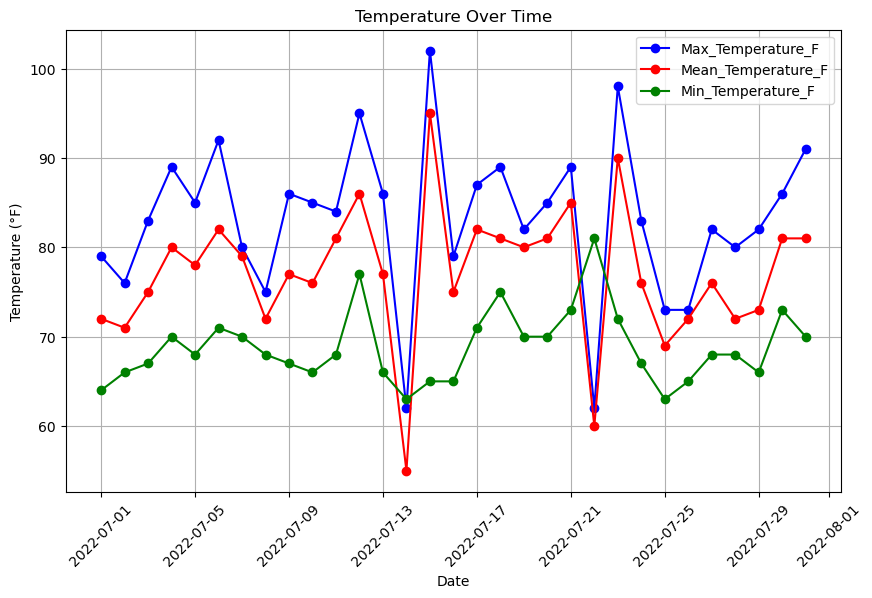

In [58]:
# weather_data['Date'] = pd.to_datetime(weather_data['Date'])

# Plot the data
plt.figure(figsize=(10, 6))

# Plot temperature data
plt.plot(weather_data['Date'], weather_data['Max_Temperature_F'], color='blue', marker='o', linestyle='-', label='Max_Temperature_F')

# Plot max temperature data
plt.plot(weather_data['Date'], weather_data['Mean_Temperature_F'], color='red', marker='o', linestyle='-', label='Mean_Temperature_F')

# Plot min temperature data
plt.plot(weather_data['Date'], weather_data['Min_Temperature_F'], color='green', marker='o', linestyle='-', label='Min_Temperature_F')

# Add labels, title, legend, and grid
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°F)')
plt.grid(True)
plt.legend()

plt.xticks(rotation=45)
plt.show()

### In Precipitation column "T" is there which is not a value but on further research found out this means "Trace amount" which means negligible or 0 hence replace "T" with 0

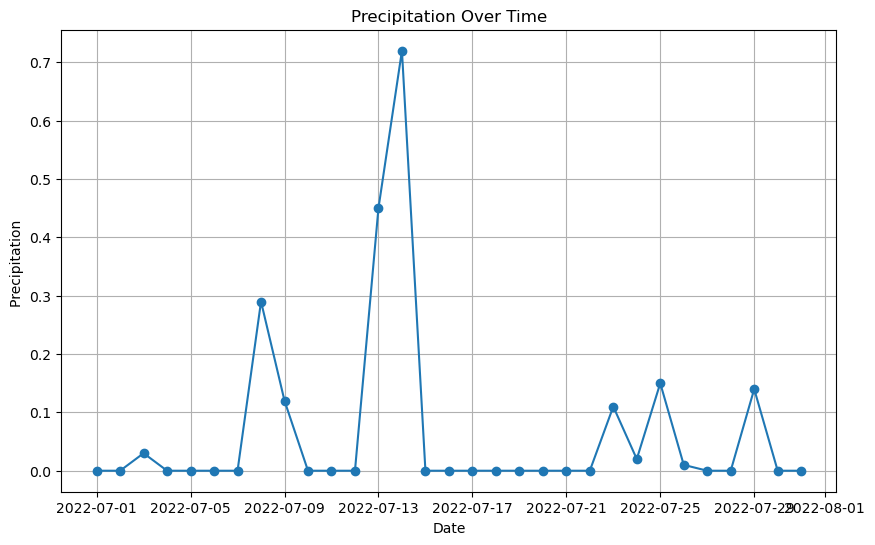

In [59]:
weather_data['Precipitation_In'] = weather_data['Precipitation_In'].replace('T', 0)
weather_data['Precipitation_In'] = weather_data['Precipitation_In'].astype(float)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(weather_data['Date'], weather_data['Precipitation_In'], marker='o', linestyle='-')
plt.title('Precipitation Over Time')
plt.xlabel('Date')
plt.ylabel('Precipitation ')
plt.grid(True)
plt.show()

## DATA ANALYSIS

### ANSWER 1 - a

In [60]:
start_counts = Final_clean_trip_data["strt_statn"].value_counts().to_dict()
start_counts_dict = {"strt_statn" : start_counts.keys(), "rides" : start_counts.values()}
start_counts_df = pd.DataFrame(start_counts_dict)
print(start_counts_df)


    strt_statn  rides
0           36    164
1           42    127
2           22    112
3           38     88
4           23     84
5           47     76
6           41     67
7           25     67
8           21     66
9           16     61
10          40     59
11          49     57
12          32     56
13          46     52
14          35     51
15          10     49
16          39     48
17          20     47
18          34     46
19           8     44
20          44     42
21          43     41
22           9     40
23          48     40
24           6     36
25          24     36
26          52     26
27          14     26
28          33     26
29          45     22
30           5     20
31          30     20
32          15     19
33          12     19
34          31     19
35          18     18
36          27     16
37          17     15
38          11     14
39           3     14
40          13     13
41          26     11
42          50     10
43          37      7
44        

### Answer 1 - b

In [61]:
# average time for each station
average_duration_per_station = Final_clean_trip_data.groupby('strt_statn')['trip_time'].mean().reset_index()
print(average_duration_per_station)

    strt_statn   trip_time
0            3   10.357143
1            5   58.350000
2            6   28.444444
3            8   89.295455
4            9   48.425000
5           10   32.775510
6           11   42.642857
7           12   20.000000
8           13   20.076923
9           14   21.807692
10          15   29.578947
11          16   45.016393
12          17   35.466667
13          18   45.055556
14          20   44.000000
15          21   48.893939
16          22   26.732143
17          23   27.059524
18          24   36.194444
19          25   24.268657
20          26   38.727273
21          27   27.937500
22          30  103.250000
23          31  109.421053
24          32   44.803571
25          33   26.961538
26          34   53.978261
27          35   47.039216
28          36   63.128049
29          37   34.285714
30          38   49.579545
31          39   46.104167
32          40   46.525424
33          41   73.492537
34          42   36.102362
35          43   58.536585
3

In [62]:
# merge station average time with station ride count 
merged_df = pd.merge(average_duration_per_station, start_counts_df, on='strt_statn', how='inner')
print(merged_df)

    strt_statn   trip_time  rides
0            3   10.357143     14
1            5   58.350000     20
2            6   28.444444     36
3            8   89.295455     44
4            9   48.425000     40
5           10   32.775510     49
6           11   42.642857     14
7           12   20.000000     19
8           13   20.076923     13
9           14   21.807692     26
10          15   29.578947     19
11          16   45.016393     61
12          17   35.466667     15
13          18   45.055556     18
14          20   44.000000     47
15          21   48.893939     66
16          22   26.732143    112
17          23   27.059524     84
18          24   36.194444     36
19          25   24.268657     67
20          26   38.727273     11
21          27   27.937500     16
22          30  103.250000     20
23          31  109.421053     19
24          32   44.803571     56
25          33   26.961538     26
26          34   53.978261     46
27          35   47.039216     51
28          36

### Answer 1 - c

In [63]:
Final_clean_trip_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1977 entries, 1 to 2001
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   trip_id            1977 non-null   int64         
 1   status             1977 non-null   object        
 2   start_date         1977 non-null   datetime64[ns]
 3   strt_statn         1977 non-null   int64         
 4   end_date           1977 non-null   datetime64[ns]
 5   end_statn          1977 non-null   int64         
 6   bike_nr            1944 non-null   object        
 7   subsc_type         1977 non-null   object        
 8   zip_code           527 non-null    object        
 9   birth_date         522 non-null    float64       
 10  gender             522 non-null    object        
 11  unique_identifier  1977 non-null   object        
 12  trip_time          1977 non-null   float64       
 13  Age                522 non-null    float64       
dtypes: datetime64

In [64]:
# Replacing the missing Age for Registered User by the median
trips_casual = Final_clean_trip_data[Final_clean_trip_data["subsc_type"] == "Casual"]
trips_regis = Final_clean_trip_data[Final_clean_trip_data["subsc_type"] == "Registered"]


trips_regis = trips_regis[trips_regis["Age"] != 0]
trips_regis.info()
# replacing nan's with median for registered users 
trips_regis['Age'].fillna(trips_regis["Age"].median(), inplace=True)

trips_regis = trips_regis[trips_regis["Age"] > 0]
trips_regis.head(2)

trip_data_filtered = pd.concat([trips_regis, trips_casual])
trip_data_filtered.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 527 entries, 1 to 1994
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   trip_id            527 non-null    int64         
 1   status             527 non-null    object        
 2   start_date         527 non-null    datetime64[ns]
 3   strt_statn         527 non-null    int64         
 4   end_date           527 non-null    datetime64[ns]
 5   end_statn          527 non-null    int64         
 6   bike_nr            516 non-null    object        
 7   subsc_type         527 non-null    object        
 8   zip_code           527 non-null    object        
 9   birth_date         522 non-null    float64       
 10  gender             522 non-null    object        
 11  unique_identifier  527 non-null    object        
 12  trip_time          527 non-null    float64       
 13  Age                522 non-null    float64       
dtypes: datetime64[

,trip_id,status,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender,unique_identifier,trip_time,Age
1,9,Closed,2022-07-16 10:21:00,23,2022-07-16 10:25:00,23,B00554,Registered,'02215,1971.0,Male,trip_id- 9 start_time- 2022-07-16 10:21:00 end...,4.0,51.0
2,10,Closed,2022-07-17 10:33:00,23,2022-07-17 10:34:00,23,B00456,Registered,'02108,NaN,NaN,trip_id- 10 start_time- 2022-07-17 10:33:00 en...,1.0,39.0
3,11,Closed,2022-07-18 10:35:00,23,2022-07-18 10:36:00,23,B00554,Registered,'02116,1986.0,Female,trip_id- 11 start_time- 2022-07-18 10:35:00 en...,1.0,36.0
9,17,Closed,2022-07-24 11:55:00,47,2022-07-24 12:13:00,40,NaN,Registered,'01867,1999.0,Male,trip_id- 17 start_time- 2022-07-24 11:55:00 en...,18.0,23.0
10,18,Closed,2022-07-25 11:55:00,47,2022-07-25 12:13:00,40,B00580,Registered,'01867,1961.0,Male,trip_id- 18 start_time- 2022-07-25 11:55:00 en...,18.0,61.0
11,19,Closed,2022-07-26 11:55:00,47,2022-07-26 12:12:00,40,B00539,Registered,'01867,1964.0,Female,trip_id- 19 start_time- 2022-07-26 11:55:00 en...,17.0,58.0
14,27,Closed,2022-07-14 12:00:00,40,2022-07-14 12:16:00,23,B00556,Registered,'02128,NaN,NaN,trip_id- 27 start_time- 2022-07-14 12:00:00 en...,16.0,39.0
15,28,Closed,2022-07-15 12:00:00,22,2022-07-15 12:01:00,22,B00316,Registered,'02115,NaN,NaN,trip_id- 28 start_time- 2022-07-15 12:00:00 en...,1.0,39.0
16,29,Closed,2022-07-16 12:00:00,22,2022-07-16 12:21:00,45,B00454,Registered,'02492,NaN,NaN,trip_id- 29 start_time- 2022-07-16 12:00:00 en...,21.0,39.0
18,31,Closed,2022-07-18 12:01:00,38,2022-07-18 12:18:00,36,B00147,Registered,'02118,1992.0,Female,trip_id- 31 start_time- 2022-07-18 12:01:00 en...,17.0,30.0


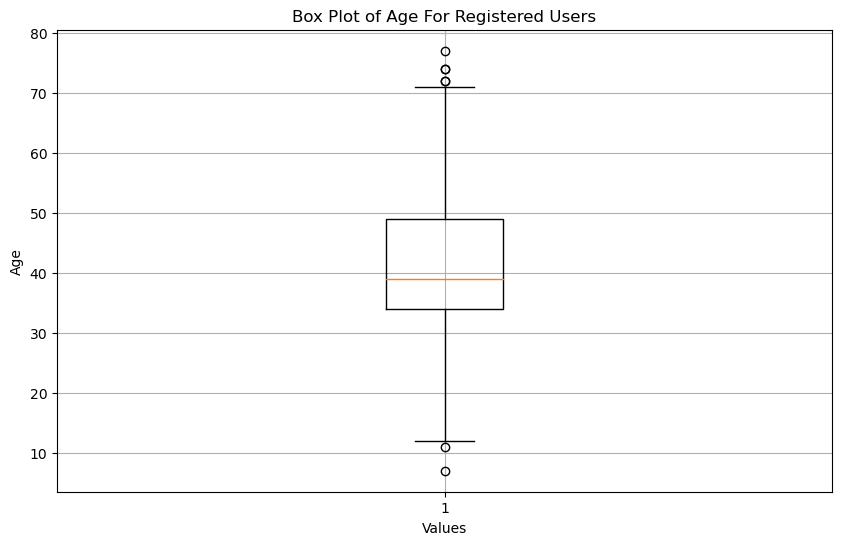

In [65]:
#Box Plot of Age For Registered Users
plt.figure(figsize=(10, 6)) 
plt.boxplot(trips_regis['Age'])  # vert=False for horizontal box plot
plt.xlabel('Values')
plt.ylabel('Age')
plt.title('Box Plot of Age For Registered Users')
plt.grid(True)
plt.show()

In [66]:
# average age for each station
average_age_per_station = trip_data_filtered.groupby('strt_statn')['Age'].mean().reset_index()
print(average_age_per_station)

    strt_statn        Age
0            3  38.916667
1            5  43.500000
2            6  43.909091
3            8  33.857143
4            9  44.666667
5           10  42.636364
6           11  44.666667
7           12  52.166667
8           13  36.000000
9           14  39.800000
10          15  31.000000
11          16  43.437500
12          17  31.000000
13          18  47.666667
14          20  42.400000
15          21  39.937500
16          22  44.830189
17          23  40.617647
18          24  45.000000
19          25  39.692308
20          26  55.000000
21          27  42.750000
22          30  33.666667
23          31  40.125000
24          32  41.200000
25          33  38.733333
26          34  40.800000
27          35  40.909091
28          36  43.234043
29          37  66.000000
30          38  45.571429
31          39  42.666667
32          40  45.142857
33          41  33.600000
34          42  41.461538
35          43  46.500000
36          44  42.818182
37          

In [67]:
#merge station average age with previous data to find the average age per station
merged_df_2 = pd.merge(merged_df, average_age_per_station, on='strt_statn', how='inner')
print(merged_df_2)

    strt_statn   trip_time  rides        Age
0            3   10.357143     14  38.916667
1            5   58.350000     20  43.500000
2            6   28.444444     36  43.909091
3            8   89.295455     44  33.857143
4            9   48.425000     40  44.666667
5           10   32.775510     49  42.636364
6           11   42.642857     14  44.666667
7           12   20.000000     19  52.166667
8           13   20.076923     13  36.000000
9           14   21.807692     26  39.800000
10          15   29.578947     19  31.000000
11          16   45.016393     61  43.437500
12          17   35.466667     15  31.000000
13          18   45.055556     18  47.666667
14          20   44.000000     47  42.400000
15          21   48.893939     66  39.937500
16          22   26.732143    112  44.830189
17          23   27.059524     84  40.617647
18          24   36.194444     36  45.000000
19          25   24.268657     67  39.692308
20          26   38.727273     11  55.000000
21        

### Answer 1 - d

In [68]:
# No imputation done even though data missing
pivot_table = trip_data_filtered.pivot_table(index='strt_statn', columns='gender', aggfunc='size', fill_value=0)

# Reset index to make start_station_id a regular column
pivot_table.reset_index(inplace=True)
pivot_table.head(4)
print(pivot_table)

gender  strt_statn  Female  Male  Other
0                3       2    10      0
1                5       0     3      3
2                6       3     6      2
3                8       1     5      1
4                9       1     4      1
5               10       4     7      0
6               11       0     5      1
7               12       1     5      0
8               13       1     1      0
9               14       3     1      1
10              15       0     5      1
11              16       2    12      2
12              17       0     2      0
13              18       2     1      0
14              20       7     3      0
15              21       4    11      1
16              22      14    29      8
17              23       6    20      7
18              24       0     2      0
19              25       8    16      2
20              26       0     1      0
21              27       1     3      0
22              30       0     2      1
23              31       3     3      1


In [69]:
#Merge data for final output
merged_df_3 = pd.merge(merged_df_2, pivot_table, on='strt_statn', how='inner')
merged_df_3.head(4)

,strt_statn,trip_time,rides,Age,Female,Male,Other
0,3,10.357143,14,38.916667,2,10,0
1,5,58.350000,20,43.500000,0,3,3
2,6,28.444444,36,43.909091,3,6,2
3,8,89.295455,44,33.857143,1,5,1


### Answer 1 - e

In [70]:
# No imputation done even though data missing
pivot_table_sub_type = trip_data_filtered.pivot_table(index='strt_statn', columns='subsc_type', aggfunc='size', fill_value=0)

# Reset index to make start_station_id a regular column
pivot_table_sub_type.reset_index(inplace=True)
pivot_table_sub_type.head(4)
print(pivot_table_sub_type)

subsc_type  strt_statn  Casual  Registered
0                    3       2          12
1                    5      14           6
2                    6      25          11
3                    8      37           7
4                    9      34           6
5                   10      38          11
6                   11       8           6
7                   12      13           6
8                   13      11           2
9                   14      21           5
10                  15      13           6
11                  16      45          16
12                  17      13           2
13                  18      15           3
14                  20      37          10
15                  21      50          16
16                  22      59          53
17                  23      50          34
18                  24      34           2
19                  25      41          26
20                  26      10           1
21                  27      12           4
22         

### Answer 2

In [71]:
#To understand the influence of weather on rides
# Extract date from start_date

trip_data_filtered['date'] = trip_data_filtered['start_date'].dt.date
trip_data_filtered.head(4)

,trip_id,status,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender,unique_identifier,trip_time,Age,date
1,9,Closed,2022-07-16 10:21:00,23,2022-07-16 10:25:00,23,B00554,Registered,'02215,1971.0,Male,trip_id- 9 start_time- 2022-07-16 10:21:00 end...,4.0,51.0,2022-07-16
2,10,Closed,2022-07-17 10:33:00,23,2022-07-17 10:34:00,23,B00456,Registered,'02108,NaN,NaN,trip_id- 10 start_time- 2022-07-17 10:33:00 en...,1.0,39.0,2022-07-17
3,11,Closed,2022-07-18 10:35:00,23,2022-07-18 10:36:00,23,B00554,Registered,'02116,1986.0,Female,trip_id- 11 start_time- 2022-07-18 10:35:00 en...,1.0,36.0,2022-07-18
9,17,Closed,2022-07-24 11:55:00,47,2022-07-24 12:13:00,40,NaN,Registered,'01867,1999.0,Male,trip_id- 17 start_time- 2022-07-24 11:55:00 en...,18.0,23.0,2022-07-24


In [72]:
trip_date_wise_dict = trip_data_filtered["date"].value_counts().to_dict()
trip_date_wise_df = pd.DataFrame({"Date" : trip_date_wise_dict.keys(), "Counts" : trip_date_wise_dict.values()})
trip_date_wise_df['Date'] = pd.to_datetime(trip_date_wise_df['Date'])
trip_date_wise_df.head(4)

,Date,Counts
0,2022-07-15,159
1,2022-07-23,147
2,2022-07-16,134
3,2022-07-25,133


In [73]:
weather_and_trip_data = pd.merge(weather_data, trip_date_wise_df , on='Date', how='inner')
weather_and_trip_data.head(4)

,Date,Max_Temperature_F,Mean_Temperature_F,Min_Temperature_F,Precipitation_In,Events,Counts
0,2022-07-14,62,55,63,0.72,Rain,106
1,2022-07-15,102,95,65,0.00,NaN,159
2,2022-07-16,79,75,65,0.00,NaN,134
3,2022-07-17,87,82,71,0.00,NaN,132


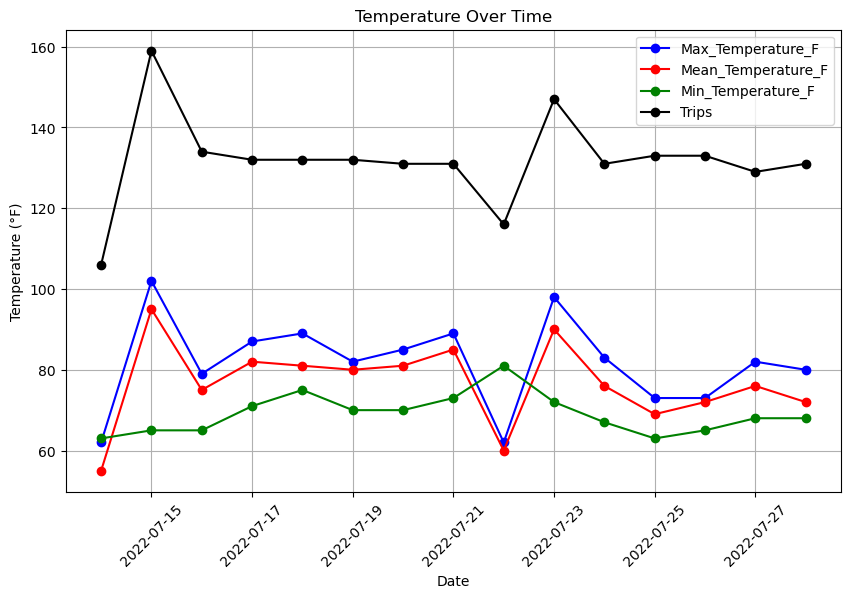

In [74]:
# weather_data['Date'] = pd.to_datetime(weather_data['Date'])

# Plot the data
plt.figure(figsize=(10, 6))

# Plot temperature data
plt.plot(weather_and_trip_data['Date'], weather_and_trip_data['Max_Temperature_F'], color='blue', marker='o', linestyle='-', label='Max_Temperature_F')

# Plot max temperature data
plt.plot(weather_and_trip_data['Date'], weather_and_trip_data['Mean_Temperature_F'], color='red', marker='o', linestyle='-', label='Mean_Temperature_F')

# Plot min temperature data
plt.plot(weather_and_trip_data['Date'], weather_and_trip_data['Min_Temperature_F'], color='green', marker='o', linestyle='-', label='Min_Temperature_F')

# Plot min temperature data
plt.plot(weather_and_trip_data['Date'], weather_and_trip_data['Counts'], color='black', marker='o', linestyle='-', label='Trips')


# Add labels, title, legend, and grid
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°F)')
plt.grid(True)
plt.legend()

plt.xticks(rotation=45)
plt.show()

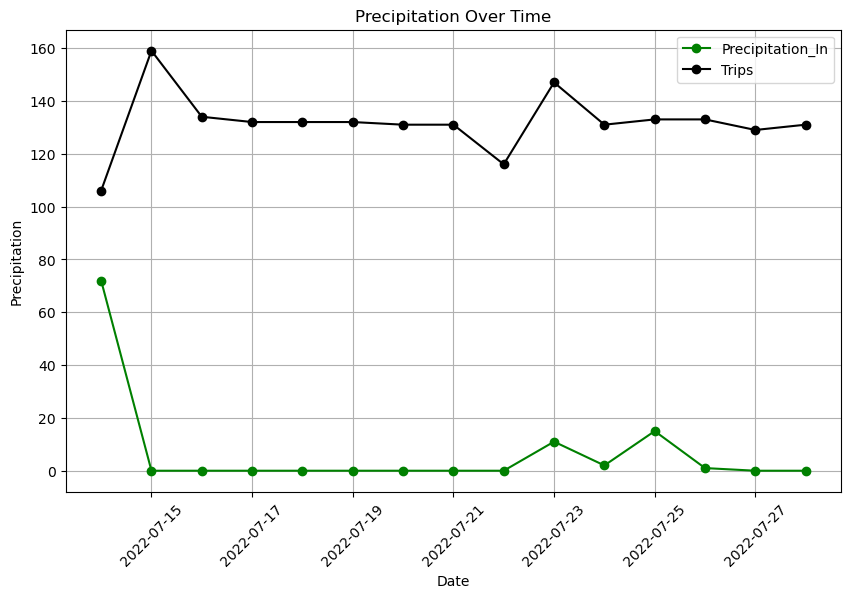

In [75]:
# weather_data['Date'] = pd.to_datetime(weather_data['Date'])

# Plot the data
plt.figure(figsize=(10, 6))

# Plot min temperature data
plt.plot(weather_and_trip_data['Date'], weather_and_trip_data['Precipitation_In'] * 100, color='green', marker='o', linestyle='-', label='Precipitation_In')

# Plot min temperature data
plt.plot(weather_and_trip_data['Date'], weather_and_trip_data['Counts'], color='black', marker='o', linestyle='-', label='Trips')


# Add labels, title, legend, and grid
plt.title('Precipitation Over Time')
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.grid(True)
plt.legend()

plt.xticks(rotation=45)
plt.show()

In [76]:
#Answer 2

# Calculate the correlation coefficient between precipitation and number of rides
correlation_precipitation_rides = (weather_and_trip_data['Precipitation_In'] * 100).corr(weather_and_trip_data['Counts'])


# Calculate the correlation coefficient between mean temperature and number of rides
correlation_temperature_rides = weather_and_trip_data['Mean_Temperature_F'].corr(weather_and_trip_data['Counts'])

print("Correlation between Precipitation and Number of Rides:", correlation_precipitation_rides)
print("Correlation between Mean Temperature and Number of Rides:", correlation_temperature_rides)







Correlation between Precipitation and Number of Rides: -0.5501400949569543
Correlation between Mean Temperature and Number of Rides: 0.8857383209065488


In [77]:
# Above output shows very high correlation between the counts of rides and Mean Temprature 